In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from imblearn.under_sampling import RandomUnderSampler


In [14]:
nltk.download('punkt')

df = pd.read_csv("assembly_bug_dataset.csv")

print(df['bug'].value_counts())

rus = RandomUnderSampler(random_state=42)
df_resampled, y_resampled = rus.fit_resample(df[['code']], df['bug'])
df_resampled['bug'] = y_resampled

bug
0    526
1    474
Name: count, dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
max_vocab_size = 2000
max_sequence_length = 75

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_resampled['code'])
sequences = tokenizer.texts_to_sequences(df_resampled['code'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding="post")


In [49]:
def fitness(weights):
    model = create_model(weights)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    loss, acc = model.evaluate(x_train[:1000], y_train[:1000], verbose=0)
    return 1 / (loss + 1e-8)

class PSO_FA_Optimizer:
    def __init__(self, population_size=10, alpha=0.5, beta=1, gamma=0.97, inertia=0.5, c1=2, c2=2):
        self.population_size = population_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.inertia = inertia
        self.c1, self.c2 = c1, c2

        self.population = [self.random_weights() for _ in range(population_size)]
        self.velocities = [[np.random.randn(*w.shape) for w in p] for p in self.population]
        self.personal_best = list(self.population)
        self.personal_best_fitness = [fitness(w) for w in self.population]
        self.global_best = self.population[np.argmax(self.personal_best_fitness)]

    def random_weights(self):
        model = create_model()
        return model.get_weights()

    def update_pso(self):
        for i in range(self.population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            inertia_component = [self.inertia * v for v in self.velocities[i]]
            cognitive_component = self.c1 * r1 * (np.array(self.personal_best[i]) - np.array(self.population[i]))
            social_component = self.c2 * r2 * (np.array(self.global_best) - np.array(self.population[i]))

            self.velocities[i] = inertia_component + cognitive_component + social_component
            self.population[i] = np.array(self.population[i]) + self.velocities[i]

    def update_firefly(self):
        for i in range(self.population_size):
            for j in range(self.population_size):
                if self.personal_best_fitness[j] > self.personal_best_fitness[i]:
                    distance = np.linalg.norm(np.array(self.personal_best[j]) - np.array(self.personal_best[i]))
                    attractiveness = self.beta * np.exp(-self.gamma * distance ** 2)
                    self.population[i] += attractiveness * (np.array(self.personal_best[j]) - np.array(self.personal_best[i])) + \
                                          self.alpha * np.random.randn(*self.population[i].shape)

    def optimize(self, iterations=10):
        for iteration in range(iterations):
            print(f"Iteration {iteration + 1}/{iterations}")
            self.update_pso()
            self.update_firefly()

            for i in range(self.population_size):
                new_fitness = fitness(self.population[i])
                if new_fitness > self.personal_best_fitness[i]:
                    self.personal_best[i] = self.population[i]
                    self.personal_best_fitness[i] = new_fitness

            self.global_best = self.population[np.argmax(self.personal_best_fitness)]
            print(f"Best Fitness: {max(self.personal_best_fitness)}")


In [53]:
y = df_resampled['bug'].values

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

def create_model(weights=None):
    model = keras.Sequential([
        keras.layers.Embedding(input_dim=max_vocab_size, output_dim=64, input_length=max_sequence_length),
        keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    if weights is not None:
        model.set_weights(weights)

    return model

#**USING SGD OPTIMIZER**

In [44]:
best_model = create_model()
best_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                   loss='binary_crossentropy', metrics=['accuracy'])

history =best_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

loss,acc = best_model.evaluate(x_test, y_test, verbose=1)
print(f"Final Test Accuracy: {acc * 100:.2f}%")


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4918 - loss: 0.6929 - val_accuracy: 0.5789 - val_loss: 0.6916
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5559 - loss: 0.6919 - val_accuracy: 0.6645 - val_loss: 0.6913
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5020 - loss: 0.6924 - val_accuracy: 0.6711 - val_loss: 0.6911
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5594 - loss: 0.6911 - val_accuracy: 0.6184 - val_loss: 0.6908
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5358 - loss: 0.6916 - val_accuracy: 0.6711 - val_loss: 0.6904
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6052 - loss: 0.6892 - val_accuracy: 0.6579 - val_loss: 0.6900
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5734 - loss: 0.6899 - val_accuracy: 0.5395 - val_loss: 0.6898
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5396 - loss: 0.6910 - val_accuracy: 0.5197 - v

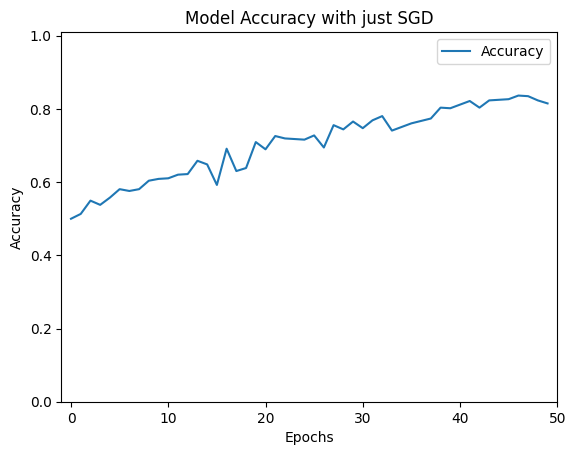

In [46]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(len(history.history['accuracy']))

plt.plot(epochs, history.history['accuracy'], label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy with just SGD')

# Set y-axis to start from 0.85
plt.ylim(0, 1.01)  # Assuming max accuracy is 1.0
plt.xlim(-1,50)

plt.show()


# **USING ADAM OPTIMIZER**

In [47]:
best_model = create_model()

adam = tf.keras.optimizers.Adam(learning_rate=0.1)

best_model.compile(optimizer=adam,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history = best_model.fit(x_train, y_train,
                         epochs=50, batch_size=4,
                         validation_split=0.2)

loss, acc = best_model.evaluate(x_test, y_test, verbose=1)
print(f"Final Test Accuracy: {acc * 100:.2f}%")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4939 - loss: 23.7862 - val_accuracy: 0.5066 - val_loss: 0.6847
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5134 - loss: 0.6934 - val_accuracy: 0.6974 - val_loss: 0.5284
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6988 - loss: 0.8032 - val_accuracy: 0.5066 - val_loss: 0.6715
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5332 - loss: 1.3942 - val_accuracy: 0.6645 - val_loss: 0.5483
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5515 - loss: 0.6796 - val_accuracy: 0.5263 - val_loss: 0.6919
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5159 - loss: 0.6987 - val_accuracy: 0.5263 - val_loss: 0.6918
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4960 - loss: 0.6978 - val_accuracy: 0.4737 - val_loss: 0.7043
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5214 - loss: 0.6957 - val_accuracy: 0.4737

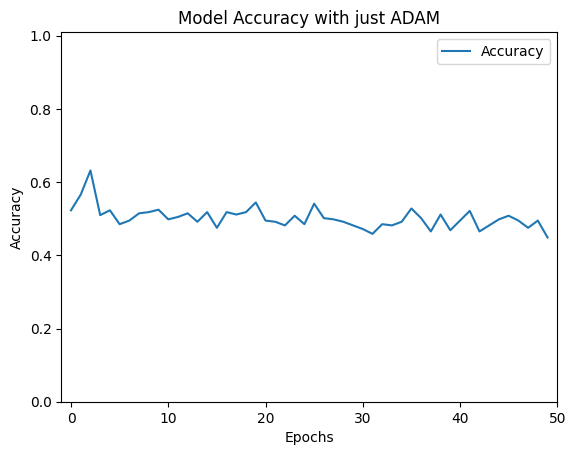

In [48]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(len(history.history['accuracy']))

plt.plot(epochs, history.history['accuracy'], label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy with just ADAM')

# Set y-axis to start from 0.85
plt.ylim(0, 1.01)  # Assuming max accuracy is 1.0
plt.xlim(-1,50)

plt.show()


# **USING HYRID PSO-FIREFLY OPTIMIZER**

In [54]:
optimizer = PSO_FA_Optimizer(population_size=10)
optimizer.optimize(iterations=10)

best_model = create_model(optimizer.global_best)
best_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
history = best_model.fit(x_train, y_train, epochs=50, batch_size=4, validation_split=0.2)

loss, acc = best_model.evaluate(x_test, y_test, verbose=1)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
Exception ignored in: <function _xla_gc_callback at 0x7a06388f9ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


Iteration 1/10
Best Fitness: 1.4459127061072286
Iteration 2/10
Best Fitness: 1.4462052325946886
Iteration 3/10
Best Fitness: 1.4462052325946886
Iteration 4/10
Best Fitness: 1.4462052325946886
Iteration 5/10
Best Fitness: 1.4462052325946886
Iteration 6/10
Best Fitness: 1.4462052325946886
Iteration 7/10
Best Fitness: 1.4462052325946886
Iteration 8/10
Best Fitness: 1.4462052325946886
Iteration 9/10
Best Fitness: 1.4462052325946886
Iteration 10/10
Best Fitness: 1.4462052325946886
Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6533 - loss: 0.6384 - val_accuracy: 0.9934 - val_loss: 0.1780
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9722 - loss: 0.1618 - val_accuracy: 1.0000 - val_loss: 0.0150
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9968 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 5

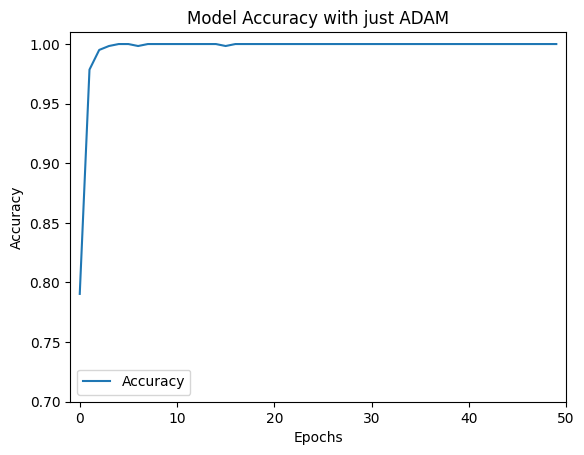

In [56]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(len(history.history['accuracy']))

plt.plot(epochs, history.history['accuracy'], label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy with just ADAM')

# Set y-axis to start from 0.85
plt.ylim(0.7, 1.01)  # Assuming max accuracy is 1.0
plt.xlim(-1,50)

plt.show()
